In [ ]:
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
# Load the data
data = pd.read_csv('/content/all_game_data.csv')

# Display the first few rows of the dataset
data.head()

,event_type,gameID,gameType,home,away,season,game_time,game_period,team,x_coordinate,y_coordinate,shot_type,is_goal,shooter,goalie,is_emptyNet,strength
0,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,2021-03-05T00:10:40Z,1,New Jersey Devils,66.0,31.0,Snap Shot,False,Jesper Bratt,Igor Shesterkin,NaN,NaN
1,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,2021-03-05T00:14:59Z,1,New York Rangers,-35.0,-6.0,Wrist Shot,False,Filip Chytil,Mackenzie Blackwood,NaN,NaN
2,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,2021-03-05T00:16:31Z,1,New Jersey Devils,41.0,-27.0,Snap Shot,False,Sami Vatanen,Igor Shesterkin,NaN,NaN
3,Goal,2020020180,R,New Jersey Devils,New York Rangers,20202021,2021-03-05T00:19:10Z,1,New Jersey Devils,61.0,5.0,Snap Shot,True,Jack Hughes,Igor Shesterkin,False,Even
4,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,2021-03-05T00:20:40Z,1,New Jersey Devils,36.0,16.0,Wrist Shot,False,Ty Smith,Igor Shesterkin,NaN,NaN


In [ ]:
# Identify the most recent season
season = 20202021

In [ ]:
# Filter the data for the most recent season
season_data = data[data['season'] == season]

# Aggregate the number of shots and goals by shot type
shot_types_data = season_data.groupby('shot_type').agg(
    total_shots=('event_type', lambda x: (x == 'Shot').sum()),
    total_goals=('is_goal', 'sum')
).reset_index()

# Sort the data by total number of shots for better visualization
shot_types_data = shot_types_data.sort_values(by='total_shots', ascending=False)
shot_types_data['goal_rate'] = shot_types_data['total_goals'] / shot_types_data['total_shots']
shot_types_data

,shot_type,total_shots,total_goals,goal_rate
6,Wrist Shot,29973,2998,0.100023
2,Slap Shot,7422,560,0.075451
3,Snap Shot,6988,812,0.116199
0,Backhand,3915,538,0.137420
4,Tip-In,2293,504,0.219799
1,Deflected,986,182,0.184584
5,Wrap-around,521,38,0.072937


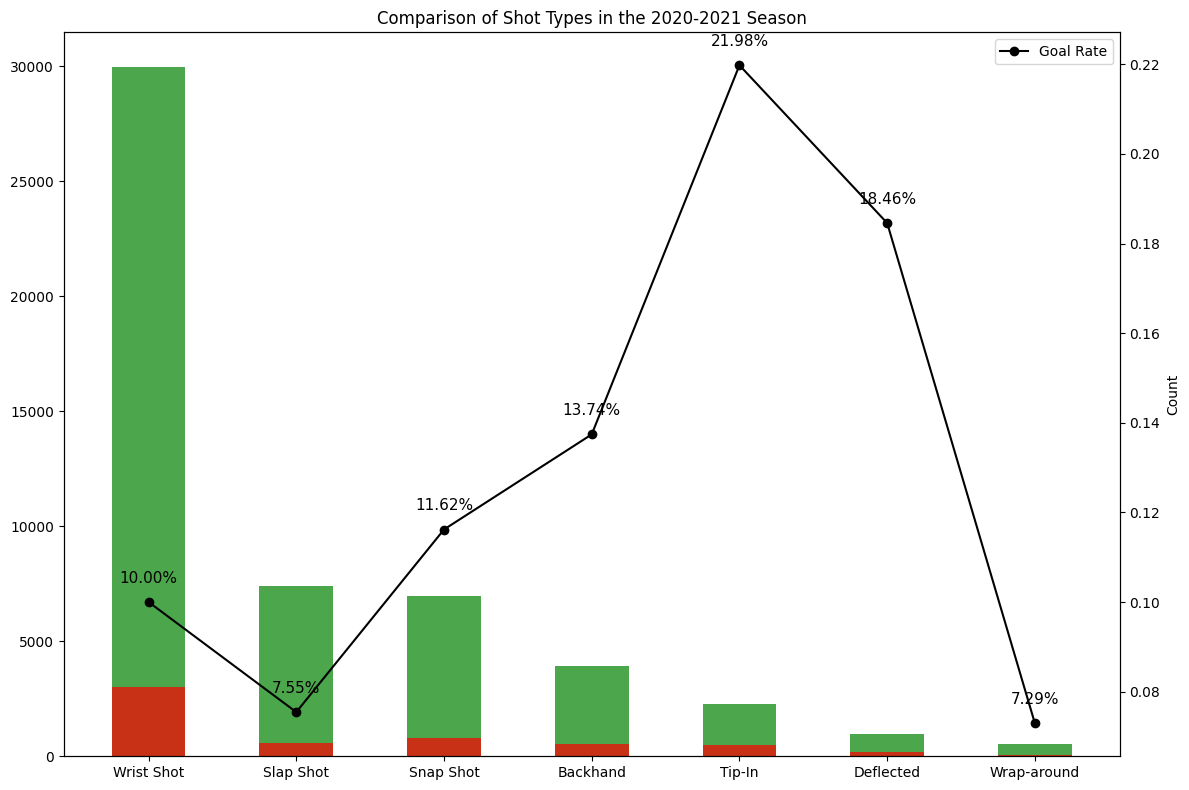

In [ ]:
# Set up the figure and axis
plt.figure(figsize=(12, 8))
bar_width = 0.5

# Plot total shots
bars1 = plt.bar(shot_types_data['shot_type'], shot_types_data['total_shots'],
                bar_width, label='Shots', color='green', alpha=0.7)

# Plot total goals
bars2 = plt.bar(shot_types_data['shot_type'], shot_types_data['total_goals'],
                bar_width, label='Goals', color='red', alpha=0.7)

# Set up the secondary y-axis (on the right) for the goal rate
ax2 = plt.gca().twinx()
ax2.plot(shot_types_data['shot_type'], shot_types_data['goal_rate'], color='black', marker='o', label='Goal Rate')
ax2.set_ylabel('Goal Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Annotate each point on the line with the exact goal rate
for i, txt in enumerate(shot_types_data['goal_rate']):
    ax2.annotate(f"{txt:.2%}", (shot_types_data['shot_type'].iloc[i], shot_types_data['goal_rate'].iloc[i]),
                 textcoords="offset points", xytext=(0,14), ha='center', fontsize=11, color='black')

plt.xlabel('Shot Type')
plt.ylabel('Count')
plt.title('Comparison of Shot Types in the 2020-2021 Season')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


ref:https://community.rapidminer.com/discussion/44904/using-the-nhl-api-to-analyze-pro-ice-hockey-data-part-1

<ipython-input-77-90142ee332c6>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels, rotation=45)


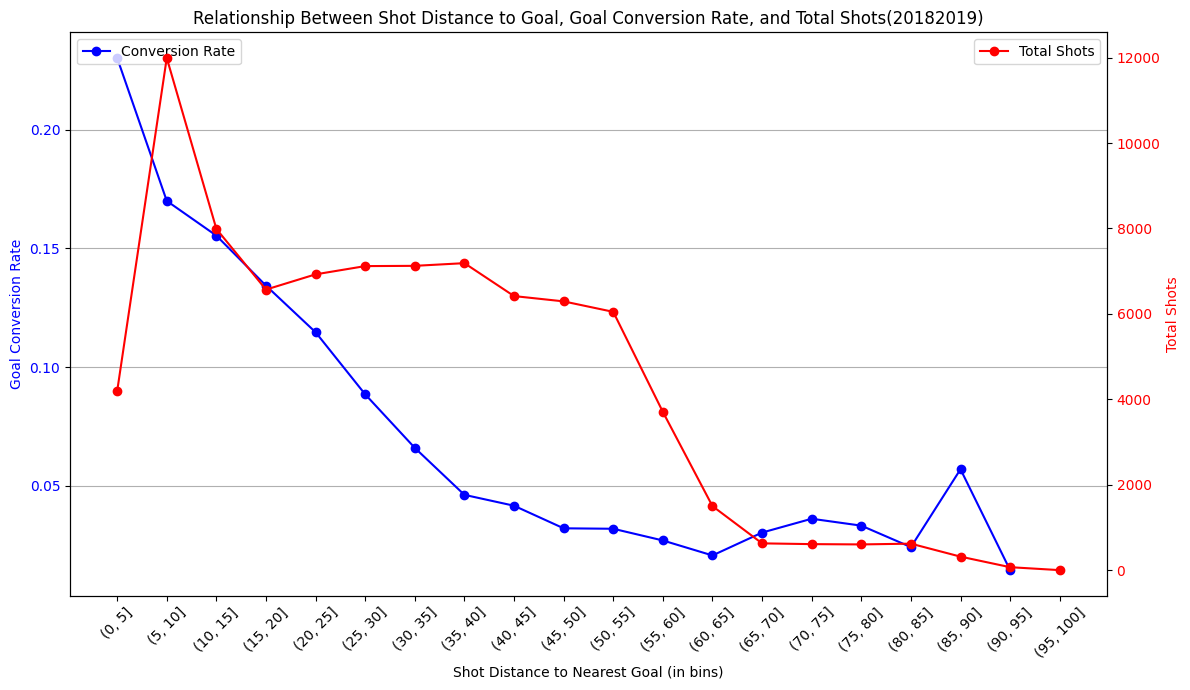

<ipython-input-77-90142ee332c6>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels, rotation=45)


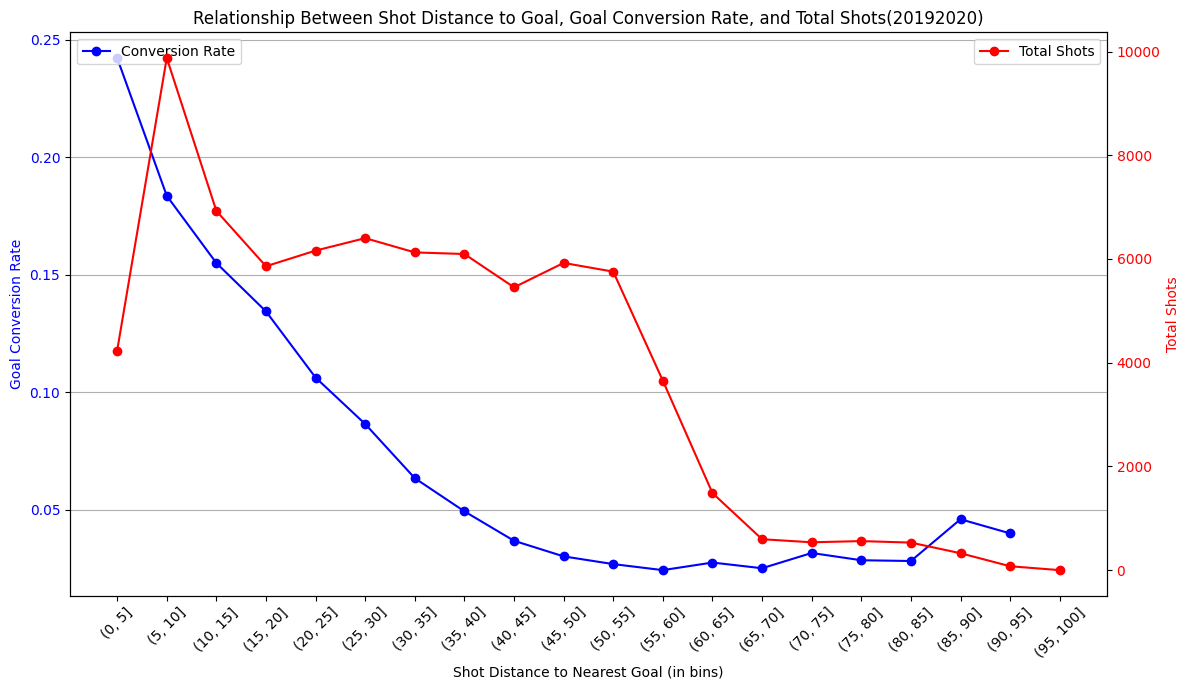

<ipython-input-77-90142ee332c6>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels, rotation=45)


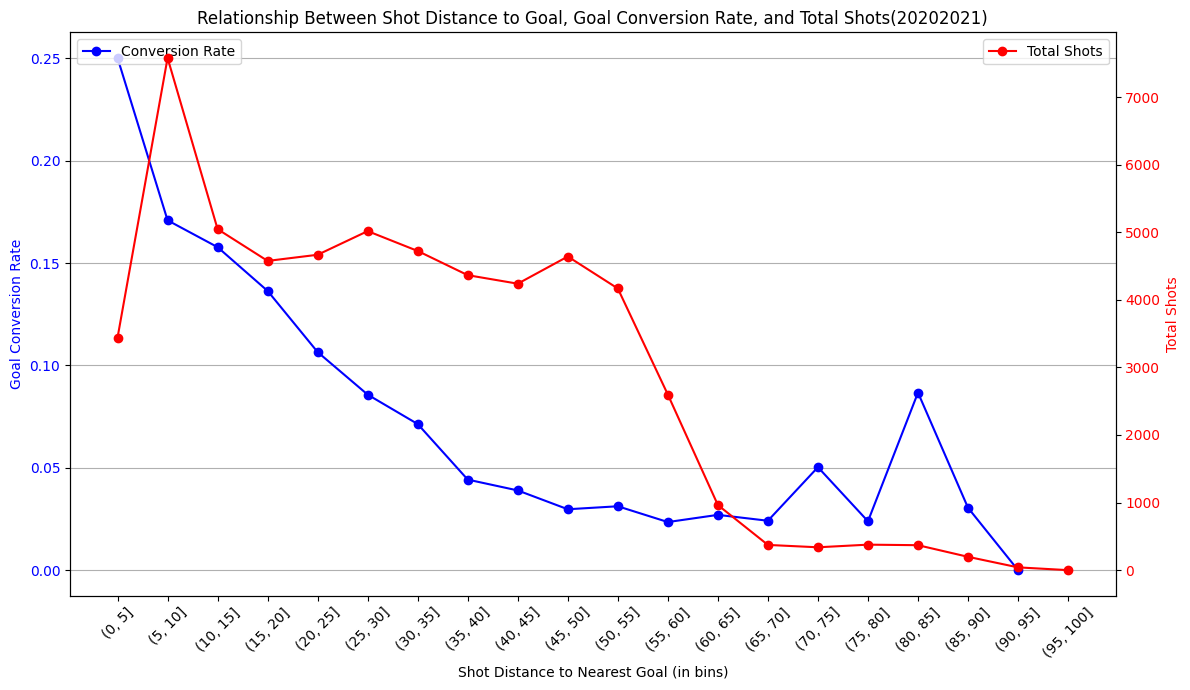

In [ ]:
seasons = [20182019, 20192020, 20202021]
for season in seasons:
    # Calculate the distance to the nearest goal (either (84,0) or (-84,0))
    data['distance_to_positive_goal'] = np.sqrt((data['x_coordinate'] - 84)**2 + data['y_coordinate']**2)
    data['distance_to_negative_goal'] = np.sqrt((data['x_coordinate'] + 84)**2 + data['y_coordinate']**2)

    # Assign the shot distance as the minimum of the two distances calculated above
    data['shot_distance_to_goal'] = data[['distance_to_positive_goal', 'distance_to_negative_goal']].min(axis=1)

    # Use the season data for the analysis
    season_data = data[data['season'] == season]

    # Create distance bins
    bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

    # Group by distance bins and compute the conversion rate
    grouped_distance = season_data.groupby(pd.cut(season_data['shot_distance_to_goal'], bins)).agg(
        total_shots=('shot_distance_to_goal', 'size'),
        total_goals=('is_goal', 'sum')
    )

    # Calculate the goal conversion rate
    grouped_distance['conversion_rate'] = grouped_distance['total_goals'] / grouped_distance['total_shots']
    grouped_distance.reset_index(inplace=True)

    # Create the initial plot
    fig, ax1 = plt.figure(figsize=(12, 7)), plt.gca()

    # Plot the conversion rate on the left y-axis
    ax1.plot(grouped_distance['shot_distance_to_goal'].astype(str), grouped_distance['conversion_rate'], marker='o', linestyle='-', color='b', label='Conversion Rate')
    ax1.set_xlabel('Shot Distance to Nearest Goal (in bins)')
    ax1.set_ylabel('Goal Conversion Rate', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(axis='y')
    ax1.legend(loc="upper left")

    # Create a second y-axis on the right side
    ax2 = ax1.twinx()
    # Plot the total shots on the right y-axis
    ax2.plot(grouped_distance['shot_distance_to_goal'].astype(str), grouped_distance['total_shots'], marker='o', linestyle='-', color='r', label='Total Shots')
    ax2.set_ylabel('Total Shots', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc="upper right")

    plt.title('Relationship Between Shot Distance to Goal, Goal Conversion Rate, and Total Shots(' + str(season) +')')

    # rotation=45
    labels = [item.get_text() for item in ax1.get_xticklabels()]
    ax1.set_xticklabels(labels, rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Filtering data for the 2020-2021 season
season_data_2020_2021 = data[data['season'] == 20202021]

# Grouping by shot type and distance bins
grouped_type = season_data_2020_2021.groupby(['shot_type', pd.cut(season_data_2020_2021['shot_distance_to_goal'], bins)]).agg(
    total_shots=('shot_distance_to_goal', 'size'),
    total_goals=('is_goal', 'sum')
).reset_index()
# Set a fixed threshold to avoid misleading result
threshold = 20
grouped_type = grouped_type[grouped_type['total_shots'] > threshold]

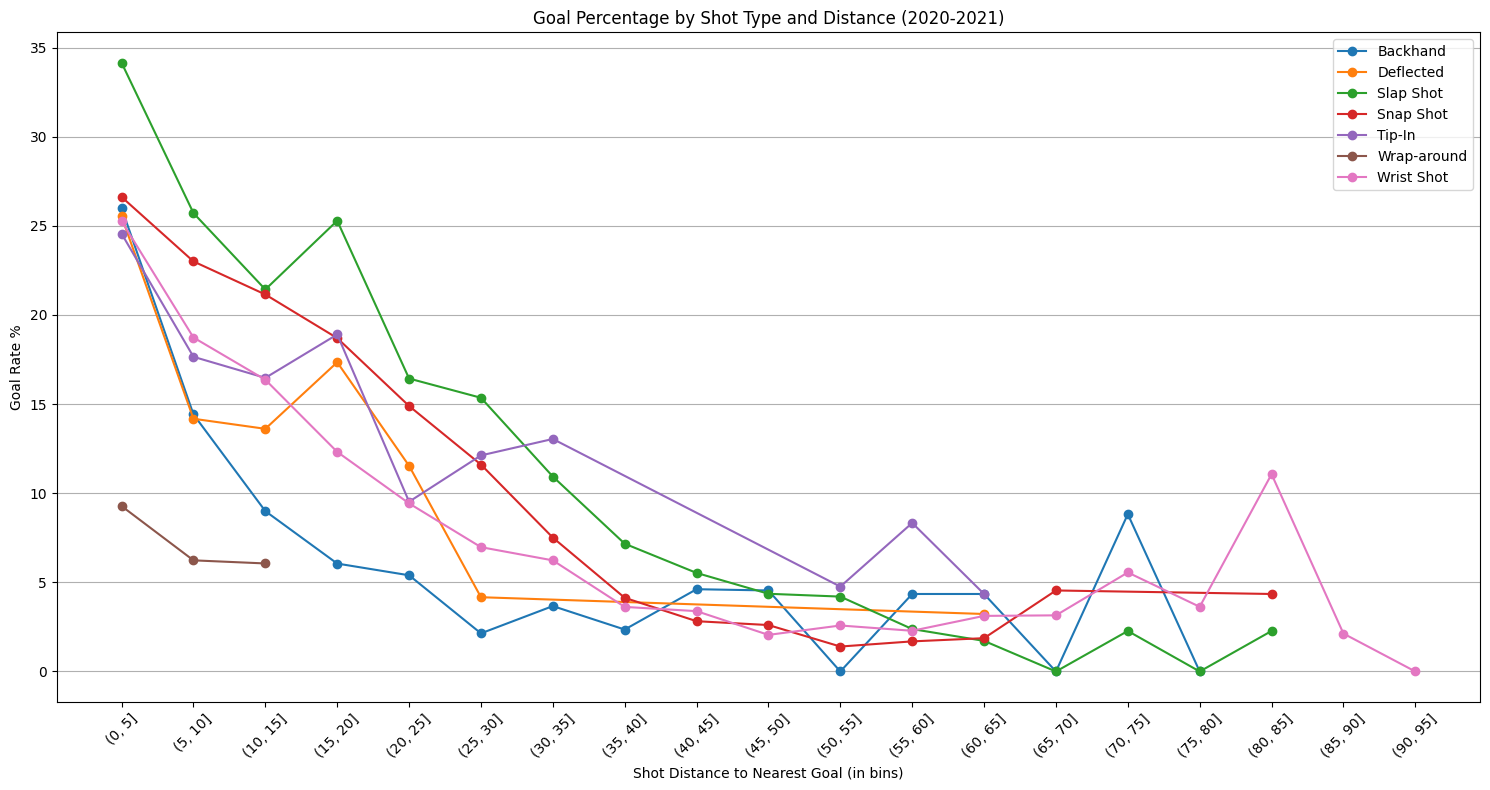

In [ ]:
# Calculating the goal percentage
grouped_type['goal_rate'] = grouped_type['total_goals'] / grouped_type['total_shots'] * 100
# Plotting
plt.figure(figsize=(15, 8))
for shot_type in grouped_type['shot_type'].unique():
    subset = grouped_type[grouped_type['shot_type'] == shot_type]
    plt.plot(subset['shot_distance_to_goal'].astype(str), subset['goal_rate'], marker='o', label=shot_type)

plt.xlabel('Shot Distance to Nearest Goal (in bins)')
plt.ylabel('Goal Rate %')
plt.title('Goal Percentage by Shot Type and Distance (2020-2021)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()